In [164]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [165]:
# Read images and store them as Pandas DataFrames

# Header = None as the CSV's do not have any headers
img1 = pd.read_csv('img1.csv', header = None)
img2 = pd.read_csv('img2.csv', header = None)
img3 = pd.read_csv('img3.csv', header = None)
img4 = pd.read_csv('img4.csv', header = None)
img5 = pd.read_csv('img5.csv', header = None)


In [166]:
def pointCoord(img):
    points_xy = {1 : (0,0), 2 : (0,0), 3 : (0,0), 3 : (0,0), 3 : (0,0), 3 : (0,0), 3 : (0,0)}
    sum = 0
    # Iterate over rows;  dataframe.shape() returns width, x counts x coordinate.
    for x, row in img.iterrows(): 
        # Iterate over columns.
        for y, value in row.items():
            # Check whether pixel at (x,y) is 1.
            # NOTE: df.at--> access via values, df.iat--> via int index
            if int(value) != 0:
                # If positive, store in list.
                # Add 1 because indexes start with 0
                points_xy[value] = (x, y)
                sum += 1
    # Preview and return coordinates that were found.
    output = list(points_xy.values())
    print(output)
    print(sum, "points found.\n")
    return(output)

In [167]:
# Calculating and storing the lists of coordinates into seperate variables.
coord1 = pointCoord(img1)    # t = 0 s
coord2 = pointCoord(img2)    # t = 10 s
coord3 = pointCoord(img3)    # t = 20 s
coord4 = pointCoord(img4)    # t = 30 s
coord5 = pointCoord(img5)    # t = 40 s

[(1876, 1199), (1866, 1110), (1795, 859), (1786, 1120), (1798, 1146), (1924, 919), (1966, 986)]
7 points found.

[(1518, 1199), (1427, 1110), (1378, 859), (1362, 1120), (1382, 1146), (1527, 919), (1673, 986)]
7 points found.

[(1021, 1199), (900, 1110), (859, 859), (840, 1120), (864, 1146), (1015, 919), (1200, 986)]
7 points found.

[(518, 1199), (427, 1110), (378, 859), (362, 1120), (382, 1146), (527, 919), (673, 986)]
7 points found.

[(144, 1199), (134, 1110), (63, 859), (54, 1120), (66, 1146), (192, 919), (234, 986)]
7 points found.



In [168]:
# Convert points (list of 2-tuples) to list of abscissae and ordinates.
# This is implemented by unpacking the input list into two lists.

def x_points(points):
    x_list = []
    for i, j in points:
        x_list.append(int(i))
    return x_list

def y_points(points):
    y_list = []
    for i, j in points:
        y_list.append(int(j))
    return y_list

In [169]:
# Function to raise list to some power.
def power(my_list, n):
    return [ x**n for x in my_list ]

# Function to multiply two lists.
def listM(list1, list2):
    return [list1[i] * list2[i] for i in range(0, len(list1))]

In [170]:
# Best Fit analysis to infer conics --> ELLIPSE AND CIRCLE.

# Function which takes in array of x and y values.
def fit_ellipse(coord):
    # Obtain arrays of respective coordinates
    X, Y = x_points(coord), y_points(coord)

    """
    Fit the coefficients a,b,c,d,e,f, representing an ellipse described by
    the formula F(x,y) = ax^2 + bxy + cy^2 + dx + ey + f = 0 to the provided
    arrays of data points x=[x1, x2, ..., xn] and y=[y1, y2, ..., yn].

    Based on the algorithm of Halir and Flusser, "Numerically stable direct
    least squares fitting of ellipses'.
    """
    
    D1 = np.vstack([power(X, 2), listM(X, Y), power(Y, 2)]).T
    D2 = np.vstack([X, Y, np.ones(len(X))]).T
    # @ here does matrix multiplication.
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    # numpy.linalg.inv() calculates inverse of a matrix.
    T = -np.linalg.inv(S3) @ S2.T
    M = S1 + S2 @ T
    C = np.array(((0, 0, 2), (0, -1, 0), (2, 0, 0)), dtype=float)
    M = np.linalg.inv(C) @ M
    # numpy.linalg.eig() returns eignevalue vector and eigenvector array
    eigval, eigvec = np.linalg.eig(M)
    con = 4 * eigvec[0]* eigvec[2] - eigvec[1]**2
    # numpy.nonzero)() gives indices of nonzero elements
    ak = eigvec[:, np.nonzero(con > 0)[0]]
    return np.concatenate((ak, T @ ak)).ravel()

In [171]:
def cart_to_pol(coeffs):

    """
    Convert the cartesian conic coefficients, (a, b, c, d, e, f), to the
    ellipse parameters, where F(x, y) = ax^2 + bxy + cy^2 + dx + ey + f = 0.
    The returned parameters are x0, y0, ap, bp, e, phi, where (x0, y0) is the
    ellipse centre; (ap, bp) are the semi-major and semi-minor axes,
    respectively; e is the eccentricity; and phi is the rotation of the semi-
    major axis from the x-axis.
    """

    # We use the formulas from https://mathworld.wolfram.com/Ellipse.html
    # which assumes a cartesian form ax^2 + 2bxy + cy^2 + 2dx + 2fy + g = 0.
    # Therefore, b, d, and f are renamed and scaled appropriately.
    
    a = coeffs[0]
    b = coeffs[1] / 2
    c = coeffs[2]
    d = coeffs[3] / 2
    f = coeffs[4] / 2
    g = coeffs[5]

    den = b**2 - a*c
    # Throw an error if it is not an ellipse
    # This is because an ellips in a non-standard position has an equation in the same 
    # form of the parabola, but with the requisite b^2 - 4ac < 0
    
    if den > 0:
        raise ValueError('coeffs do not represent an ellipse: b^2 - 4ac must'
                         ' be negative!')

    # The location of the ellipse centre.
    x0, y0 = (c*d - b*f) / den, (a*f - b*d) / den

    num = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    fac = np.sqrt((a - c)**2 + 4*b**2)
    
    # The semi-major and semi-minor axis lengths (these are not sorted).
    ap = np.sqrt(num / den / (fac - a - c))
    bp = np.sqrt(num / den / (-fac - a - c))

    # Sort the semi-major and semi-minor axis lengths but keep track of
    # the original relative magnitudes of width and height.
    width_gt_height = True
    if ap < bp:
        width_gt_height = False
        ap, bp = bp, ap

    # The eccentricity.
    r = (bp/ap)**2
    if r > 1:
        r = 1/r
    e = np.sqrt(1 - r)

    # The angle of anticlockwise rotation of the major-axis from x-axis.
    if b == 0:
        phi = 0 if a < c else np.pi/2
    else:
        phi = np.arctan((2.*b) / (a - c)) / 2
        if a > c:
            phi += np.pi/2
    if not width_gt_height:
        # Ensure that phi is the angle to rotate to the semi-major axis.
        phi += np.pi/2
    phi = phi % np.pi

    return x0, y0, ap, bp, e, phi

In [172]:
def get_ellipse_pts(params, npts=100, tmin=0, tmax=2*np.pi):
    
    """
    Return npts (Non-parametric time scaling algorithm) points on the ellipse described by the params = x0, y0, ap,
    bp, e, phi for values of the parametric variable t between tmin and tmax.
    """
    
    x0, y0, ap, bp, e, phi = params
    
    # A grid of the parametric variable, t.
    t = np.linspace(tmin, tmax, npts)
    
    # Some more maths.
    x = x0 + ap * np.cos(t) * np.cos(phi) - bp * np.sin(t) * np.sin(phi)
    y = y0 + ap * np.cos(t) * np.sin(phi) + bp * np.sin(t) * np.cos(phi)
    return x, y

axes are 224.4249043285414 139.99350457192844


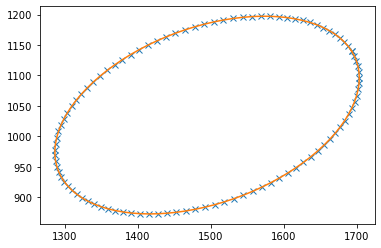

axes are 224.4249043285414 139.99350457192844


In [173]:
# To run the algorithm on our data.

# Store output of fitting in coeffs.
coeffs = fit_ellipse(coord2)

#print('Exact parameters:')
#print('x0, y0, ap, bp, phi =', x0, y0, ap, bp, phi)
#print('Fitted parameters:')
#print('a, b, c, d, e, f =', coeffs)

# ab, bp --> Semi-major and minor axes, e is eccentricity.
x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)

#print('x0, y0, ap, bp, e, phi = ', x0, y0, ap, bp, e, phi)

# Given points.
plt.plot(x, y, 'x')

# Print(x, y)

#Get npts points, and plot.
x, y = get_ellipse_pts((x0, y0, ap, bp, e, phi))
plt.plot(x, y)
plt.show()

# Get Semi-major and minor axes.
print("axes are", ap, bp)